*Note*: This is Jai Bhagat's edited version of Jack Lindsey's SAE tutorial. 

For details about the original tutorial, see here: https://x.com/Jack_W_Lindsey/status/1825760546177822854

# Introduction to sparse autoencoders (SAEs) for interpretability

Sparse autoencoders (SAEs) are a tool for decomposing neural network model activations into more interpretable components. SAEs are an instance of a family of “sparse dictionary learning” algorithms that seek to express data as a weighted linear sum of sparsely active components.

Sparse dictionary learning-based approaches to interpreting neural networks are based on two assumptions:

1. *The linear representation hypothesis*: the claim that neural networks represent meaningful concepts ("features") as linear directions in their activation spaces

2. *The superposition hypothesis*: the claim that ground-truth features are only sparsely "active" (i.e. only relevant a small fraction of the time), and thus a large number of features can be encoded with minimal interference in a much smaller neural network representation. While neither of these assumptions has been conclusively established, they have proven quite useful.

In the past year, a variety of groups have shown that overcomplete SAEs are capable of decomposing a model's activity into semantically meaningful components that shed light on how a model represents concepts and computes outputs. A standard overcomplete SAE consists of two layers. The first layer (encoder) maps the input (the other model's activity) to a higher-dimensional layer via a learned linear transformation followed by a ReLU nonlinearity. We refer to the units of this higher-dimensional layer (the hidden layer in the Autoencoder, sometimes called the "Autoencoder latent space") as **SAE features**. The second layer (decoder) attempts to reconstruct the model activations via a linear transformation of the feature activations. In the standard SAE formulation, the model is trained to minimize a combination of (1) reconstruction error and (2) an L1 regularization penalty on the feature activations, which incentivizes sparsity.

Note that recent work suggests that different objective functions and/or architectures can improve SAE performance, but in this tutorial we will focus on the basic setup.

<div>
<img src="./superposition.png" />
</div>

(Image from [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html))

*Note*: Until reaching header "(1)", can just run the code cells, don't need to read.

In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os
from dataclasses import dataclass
from typing import Callable, List, Optional, Tuple, Union

import einops
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import torch
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from rich import print as rprint
from torch import Tensor, nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from transformer_lens.utils import to_numpy

In [2]:
"""Create some helper variables and functions we'll use downstream."""

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # allow for multiple versions of OpenMP to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # set cuda device
print(f"{device=}")
print(f"{torch.__version__=}")
update_layout_set = {  # plotly fig layout params to be used as kwargs in `hist` below
    "xaxis_range",
    "yaxis_range",
    "hovermode",
    "xaxis_title",
    "yaxis_title",
    "colorbar",
    "colorscale",
    "coloraxis",
    "title_x",
    "bargap",
    "bargroupgap",
    "xaxis_tickformat",
    "yaxis_tickformat",
    "title_y",
    "legend_title_text",
    "xaxis_showgrid",
    "xaxis_gridwidth",
    "xaxis_gridcolor",
    "yaxis_showgrid",
    "yaxis_gridwidth",
    "yaxis_gridcolor",
    "showlegend",
    "xaxis_tickmode",
    "yaxis_tickmode",
    "margin",
    "xaxis_visible",
    "yaxis_visible",
    "bargap",
    "bargroupgap",
    "coloraxis_showscale",
    "xaxis_tickangle",
    "yaxis2_range",
}


def hist(
    tensor: Union[torch.Tensor, List[torch.Tensor], List[List], np.ndarray],  # input data for hist
    renderer: str | None,  # renderer for plotly fig
    **kwargs  # layout params to update plotly fig
):
    """Enhances plotly histogram functions by accepting various data formats and layout params."""
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    kwargs_pre.pop("draw", True)
    return_fig = kwargs_pre.pop("return_fig", False)
    if isinstance(tensor, list):
        if isinstance(tensor[0], torch.Tensor):
            arr = [to_numpy(tn) for tn in tensor]
        elif isinstance(tensor[0], list):
            arr = [np.array(tn) for tn in tensor]
        else:
            arr = np.array(tensor)
    else:
        arr = to_numpy(tensor)
    if "modebar_add" not in kwargs_post:
        kwargs_post["modebar_add"] = [
            "drawline",
            "drawopenpath",
            "drawclosedpath",
            "drawcircle",
            "drawrect",
            "eraseshape",
        ]
    add_mean_line = kwargs_pre.pop("add_mean_line", False)
    names = kwargs_pre.pop("names", None)
    if "barmode" not in kwargs_post:
        kwargs_post["barmode"] = "overlay"
    if "bargap" not in kwargs_post:
        kwargs_post["bargap"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "autosize" not in kwargs_post:
        kwargs_post["autosize"] = False

    # If `arr` has a list of arrays, then just doing px.histogram doesn't work annoyingly enough.
    # (This is janky, even for my functions!)
    if isinstance(arr, list) and isinstance(arr[0], np.ndarray):
        assert "marginal" not in kwargs_pre, "Can't use `marginal` with a list of arrays"
        for thing_to_move_from_pre_to_post in ["title", "template", "height", "width", "labels"]:
            if thing_to_move_from_pre_to_post in kwargs_pre:
                kwargs_post[thing_to_move_from_pre_to_post] = kwargs_pre.pop(
                    thing_to_move_from_pre_to_post
                )
        if "labels" in kwargs_post:
            kwargs_post["xaxis_title_text"] = kwargs_post["labels"].get("x", "")
            kwargs_post["yaxis_title_text"] = kwargs_post["labels"].get("y", "")
            del kwargs_post["labels"]
        fig = go.Figure(layout=go.Layout(**kwargs_post))
        if "nbins" in kwargs_pre:
            kwargs_pre["nbinsx"] = int(kwargs_pre.pop("nbins"))
        for x in arr:
            fig.add_trace(
                go.Histogram(x=x, name=names.pop(0) if names is not None else None, **kwargs_pre)
            )
    else:
        fig = px.histogram(x=arr, **kwargs_pre).update_layout(**kwargs_post)
        if names is not None:
            for i in range(len(fig.data)):
                fig.data[i]["name"] = names[i // 2 if "marginal" in kwargs_pre else i]

    if add_mean_line:
        if arr.ndim == 1:
            fig.add_vline(
                x=arr.mean(),
                line_width=3,
                line_dash="dash",
                line_color="black",
                annotation_text=f"Mean = {arr.mean():.3f}",
                annotation_position="top",
            )
        elif arr.ndim == 2:
            for i in range(arr.shape[0]):
                fig.add_vline(
                    x=arr[i].mean(),
                    line_width=3,
                    line_dash="dash",
                    line_color="black",
                    annotation_text=f"Mean = {arr.mean():.3f}",
                    annotation_position="top",
                )
    
    return fig if return_fig else fig.show(renderer=renderer)

device=device(type='cuda')
torch.__version__='2.5.1+cu121'


# (1) Training sparse autoencoders on a toy model with known ground-truth features

## Problem and Toy Model setup and training

To begin, we will consider a toy model of neural network activations which we can use to experiment with sparse autoencoders. Our toy model embeds a set of 5 ground-truth "features" (sparsely active, uncorrelated variables whose activity is denoted with a five-dimensional vector $x$) into a lower-dimensional (2D) space (hidden activations $h$), in such a way that they can be reconstructed accurately ($x'$ is the attempted reconstruction) with a single-layer decoder.  

$$
\begin{aligned}
h &= W x \hspace{1em} ... \hspace{1em} [2 \times 5] @ [5 \times 1] \rightarrow [2 \times 1] \\
x' &= \operatorname{ReLU}(W^T h + b) \hspace{1em} ... \hspace{1em} [5 \times 2] @ [2 \times 1] + [2 \times 1] \rightarrow [5 \times 1]
\end{aligned}
$$


In other words our toy model is itself the opposite of a sparse autoencoder! It attempts to near-losslessly compress high-dimensional information (in this case five uncorrelated variables) into a lower-dimensional space -- a kind of representation we call *superposition* (we can refer to our toy model as a "toy model of superposition"). This is meant to (very roughly!) model what we believe is going on in large deep learning models like LLMs, which manage to represent, and compute with, a large variety of concepts despite possessing a relatively small number of neurons.

The job of our sparse autoencoder will be to *reverse* this compression process -- extracting the latent sparse and high-dimensional (5D in this example) features from the dense, low-dimensional (2D in this example) model activations.

In [3]:
"""Create Toy Model of NN Activations (Superposition)."""

# We use a constant learning rate in our learning rate scheduler for our toy model optimizer.
def constant_lr(*_):
    """Returns a constant learning rate."""
    return 1.0


@dataclass
class Config:
    """Config to set some params for (Toy) `Model`."""
    # We specify `n_instances` in a single training loop to let us sweep over sparsity or other 
    # hyperparameters efficiently. We can treat `n_instances` kinda like another batch dimension.
    n_instances: int  # number of model instances to optimize in parallel
    n_feat_gt: int = 5  # number of ground truth features in the generated data
    n_hidden: int = 2  # number of hidden units in the model


class Model(nn.Module):
    """Toy Model of NN Activations (Superposition)."""
    # We specify the shape of the model params using the typing package.
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)
    W: Float[Tensor, "n_instances n_hidden n_feat_gt"]
    b_final: Float[Tensor, "n_instances n_feat_gt 1"]

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]],  # prob of each feature being nonzero
        device: torch.device = device
    ):
        """Sets model parameters and feature probabilities."""
        super().__init__()
        self.cfg = cfg

        # Broadcast feature probability to all features to all instances.
        feature_probability = torch.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to(
            (cfg.n_instances, cfg.n_feat_gt)
        )

        # Initialize params and send them to device.
        self.W = nn.Parameter(
            nn.init.xavier_normal_(torch.empty((cfg.n_instances, cfg.n_hidden, cfg.n_feat_gt)))
        )
        self.b_final = nn.Parameter(torch.zeros((cfg.n_instances, cfg.n_feat_gt)))
        self.to(device)

    def forward(
        self, features: Float[Tensor, "batch_sz n_instances n_feat_gt"]
    ) -> Float[Tensor, "batch_sz n_instances n_feat_gt"]:
        """Computes the hidden activations, and then the feature reconstruction attempt."""
        hidden = einops.einsum(
            self.W,
            features,
            "n_instances n_hidden n_feat_gt, batch_sz n_instances n_feat_gt " 
            "-> batch_sz n_instances n_hidden",
        )
        out = einops.einsum(
            self.W,
            hidden,
            "n_instances n_hidden n_feat_gt, batch_sz n_instances n_hidden "
            "-> batch_sz n_instances n_feat_gt",
        )
        return F.relu(out + self.b_final)

    def generate_batch(self, batch_sz: int) -> Float[Tensor, "batch_sz n_instances n_feat_gt"]:
        """Generates a batch of data (features of binary values)."""
        # Generate features and "feature absence seeds".
        feat = torch.rand(
            (batch_sz, self.cfg.n_instances, self.cfg.n_feat_gt), device=self.W.device
        )
        feat_seeds = torch.rand(
            (batch_sz, self.cfg.n_instances, self.cfg.n_feat_gt), device=self.W.device,
        )
        feat_is_absent = feat_seeds <= self.feature_probability
        
        # Create batch from features with some zerod.
        batch = torch.where(feat_is_absent, feat, 0.0)
        return batch

    def calculate_loss(
        self,
        out: Float[Tensor, "batch n_instances n_feat_gt"],
        batch: Float[Tensor, "batch n_instances n_feat_gt"],
    ) -> Float[Tensor, ""]:
        """Calculates the loss for a given batch, using loss described in the Toy Models paper."""
        error = (batch - out) ** 2
        loss = einops.reduce(error, "batch_sz n_instances n_feat_gt -> n_instances", "mean").sum()
        return loss

    def optimize(
        self,
        batch_sz: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """Optimizes the model using the given hyperparameters."""
        optimizer = torch.optim.Adam(list(self.parameters()), lr=lr)
        progress_bar = tqdm(range(steps))

        for step in progress_bar:
            # Update learning rate.
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Optimize.
            optimizer.zero_grad()
            batch = self.generate_batch(batch_sz)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar.
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item() / self.cfg.n_instances, lr=step_lr)

First, we'll optimize our toy model to compress sparsely active features, and generate an example batch of model activations.

In [4]:
"""Create activations from Toy Model of Superposition."""

torch.manual_seed(0)  # set torch rng seed for reproducibility
feature_probability = 0.01  # sparsity of the ground-truth "features"

# Set up and train model.
cfg = Config(
    n_instances=8,  # use multiple toy models in parallel to see robustness/consistency
    n_feat_gt=5,  # ground truth features in the toy model
    n_hidden=2,  # dimensions in the toy model activations
)
model = Model(
    cfg=cfg,
    device=device,
    feature_probability=feature_probability
)
model.optimize(steps=10_000)

# Generate activations from the model.
batch_sz = 1000
features = model.generate_batch(batch_sz)  # -> [batch_sz, n_instances, n_features_gt]
activations = einops.einsum(
    features,
    model.W,
    "batch_sz instances features, instances hidden features -> instances hidden batch_sz",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
"""Look at some tensor shapes"""

print(f"{model.W.shape=}\n\n{features.shape=}\n\n{activations.shape=}")

model.W.shape=torch.Size([8, 2, 5])

features.shape=torch.Size([1000, 8, 5])

activations.shape=torch.Size([8, 2, 1000])


In [6]:
"""Look at some example feature values and activations"""

print("Single feature activation of features 1, 3 in model instances 4, 7 (respectively):\n")
print(features[3])  # feature vectors for all model instances for the fourth batch
print(activations[:, :, 3])  # activations for all model instances for the fourth batch
print("---\n")

print("Two-feature activations in a model:\n")  # rare
batch, instance, feat = features.shape
inner_flag = False
# Find the first batch with more than one feature active in a single model instance.
for i in range(batch):
    if inner_flag:
        break
    for j in range(instance):
        if features[i, j].count_nonzero() > 1:
            inner_flag = True
            break
print(features[i - 1])
print(activations[:, :, i - 1])

Single feature activation of features 1, 3 in model instances 4, 7 (respectively):

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2135, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6634, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')
tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.2016, -0.1450],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.7726, -0.0214],
        [ 0.0000,  0.0000]], device='cuda:0', grad_fn=<SelectBackward0>)
---

Two-feature activations in a model:

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3403, 0.0000, 0.9667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.00

Now we'll look at how the model maps features from the original 5-d feature space to the 2-d activation space.

Since the model was trained on sparse activations (typically where only 1 if not 0 features were "found active" in the example), the model learned to represent each feature as a distinct direction (the weights took distinct values for each feature) in the 2D activation space.

The last two dimensions of the model's weight tensor (`model.W`) represents the "direction vector" in the 2-d activation space corresponding to each of the 5 features. (These "direction vectors" show how the presence of each feature, when active, influences the position in the 2D activation space. If an activation has a value further along a direction vector, this can be interpreted as an increased representation of that feature for that activation.)

We will plot the direction vectors as black lines from the origin with circles at the end (the weight values) for each of the 5 features.

We can also visualize our batch of example activations (blue x's). In this example, our features are so sparse that usually at most one feature is active at a time, and so the activations are aligned with a single feature direction. Sometimes more than one feature is active, resulting in activations that are linear combinations of multiple feature directions.

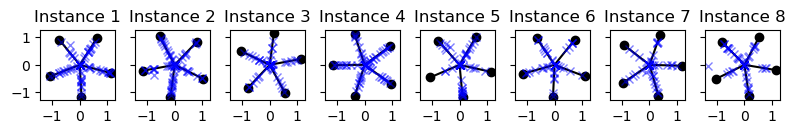

In [7]:
"""Plot activations on top of features (model weights)."""

def plot_features_in_2d(
        W: Float[Tensor, "n_instances n_hidden n_feat_gt"],
        activations: Optional[Float[Tensor, "n_instances n_hidden batch_sz"]] = None
    ):
    """Plot model features in 2-d with a subplot for each model instance."""
    fig, axs = plt.subplots(
        1, cfg.n_instances, figsize=(cfg.n_instances, 4), sharex=True, sharey=True
    )

    # Loop over each model instance, plotting the feature vectors and activations.
    for i in range(cfg.n_instances):
        ax = axs[i]
        ax.set_aspect("equal")
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([-1, 0, 1])

        # Plot feature direction vectors.
        for j in range(cfg.n_feat_gt):
            x, y = W[i, :, j].detach().cpu()
            ax.plot([0, x], [0, y], "k-")  # line from origin to point
            ax.plot(x, y, "o", color="k")  # arrow marker

        # Plot example activations.
        if activations is not None:  # ignore '0' activations
            for d in range(batch_sz):
                x, y = activations[i, :, d].detach().cpu()
                ax.plot(x, y, color="blue", marker="x", alpha=0.5)

        ax.set_title(f"Instance {i+1}", fontsize=12)

    plt.tight_layout()
    plt.show()


plot_features_in_2d(model.W, activations=activations)

## SAE setup and training

We call the hidden activations of the autoencoder **autoencoder features**.

Notation:

- (5) `n_features_gt` = number of ground-truth features in the data generating process.
- (2) `n_hidden` = number of hidden dimensions of the underlying model. 
- (2) `n_input_ae` = number of input dimensions for the **autoencoder**.
- (5) `n_hidden_ae` = number of hidden dimensions / neurons / features of your **autoencoder**. We require `n_hidden_ae >= n_features_gt` for our autoencoder to have a chance of reconstructing all the features. Usually we'll have `n_hidden_ae == n_features_gt` in this section.

We're going to train a sparse autoencoder to try to infer the underlying features -- their activity values and their embedding directions -- from the model activations alone.  We'll take in the hidden state activations $h$, map them to a larger ("overcomplete") hidden state $z$, then reconstruct the original hidden state $h$ from $z$.

$$
\begin{aligned}
z &= \operatorname{ReLU}({W_{enc}}^T(h - b_{dec}) + b_{enc}) \hspace{1em} ... \hspace{1em} [5 \times 2] @ ([2 \times 1] - [2 \times 1]) + [5 \times 1] \rightarrow [5 \times 1] \\
h' &= {W_{dec}}^Tz + b_{dec}  \hspace{1em} ... \hspace{1em} [2 \times 5] @ [5 \times 1] + [2 \times 1] \rightarrow [2 \times 1]
\end{aligned}
$$

### Some important notes on training the SAE

- We're training our autoencoder on the hidden state activations $h$ of our model, rather than from the original randomly generated ground-truth features $x$. We don't generate data directly from the `Model.generate_batch` method, but rather we use this method to generate features then use those features to generate hidden state activations for our model, which we use as the input to our autoencoder.

- Our autoencoder loss is the sum of the $l1$ and $l2$ losses returned by the `forward` function.

- The `optimize` method logs some more interesting data, including the fraction of hidden state activations $h$ which are active, for each instance. It also returns these values as a tensor at the end.

- We normalize the decoder weights at each optimization step. Normalizing the decoder weights does the following:

1. Prevents the model from making features artificially sparse by making decoder weights very large (which would allow very small activations to reconstruct the original activations).
2. Makes it easier to compare features importance in the activations reconstruction.
3. Makes the feature directions more interpretable (in this particular case. The weights will be on the same scale as the original feature directions).

<details>
<summary>Question - in the formulas above (for the Toy Model and then for the SAE), using the notation defined above, what are the shapes of x, x', z, h, and h' ?</summary>

Ignoring batch and instance dimensions:

- `x` and `x'` are vectors of shape `(n_features_gt,)`
- `z` is a vector of shape `(n_hidden_ae,)`, which will usually be equal to or larger than `n_features_gt` (so that our autoencoder is overcomplete)
- `h` and `h'` are vectors of shape `(n_input_ae,)`, also equal to `(n_hidden,)`

Including batch and instance dimensions, all shapes `(d,)` turn into `(batch_size, n_instances, d)`.

</details>

We define an `AEConfig` class below. Its arguments are `n_instances`, `n_input_ae` (which is the size of the toy model's hidden layer, i.e. the input into the autoencoder), and `n_hidden_ae` (which is the size of the **AutoEncoder's** hidden layer). In our case, we'll set this to be the same as the ground-truth number of features `n_features_gt` of the toy model (in real applications, you don't know the ground truth number of features!!)

In [8]:
"""Create SAE for taking in Toy Model's activations and finding features."""

@dataclass
class AutoEncoderConfig:
    """Config to set some params for (Toy) `AutoEncoder`."""
    n_instances: int  # number of model instances to optimize in parallel
    n_input_ae: int  # number of input units to the autoencoder
    n_hidden_ae: int  # number of hidden units in the autoencoder
    l1_coeff: float = 0.5  # relative weight of sparsity_loss : activations_reconstruction_loss


class AutoEncoder(nn.Module):
    """SAE for finding features in the activations of the Toy Model."""
    # Shapes of weights and biases for the encoder and decoder in the SAE.
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: AutoEncoderConfig):
        """Sets model parameters."""
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(
            nn.init.xavier_normal_(torch.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae)))
        )
        self.W_dec = nn.Parameter(
            nn.init.xavier_normal_(torch.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae)))
        )
        self.b_enc = nn.Parameter(torch.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(torch.zeros(cfg.n_instances, cfg.n_input_ae))
        self.to(device)

    def forward(self, h: Float[Tensor, "batch_sz n_instances n_hidden"]):
        """Computes loss as a function of SAE feature sparsity and activations reconstructions."""
        # Compute encoder hidden activations.
        z = F.relu(
            einops.einsum(
                self.W_enc,
                h - self.b_dec,  # center the activations around bias ("baseline" activation)
                "n_instances n_input_ae n_hidden_ae, batch_sz n_instances n_input_ae  "
                "-> batch_sz n_instances n_hidden_ae"
            )
            + self.b_enc
        )

        # Compute reconstructed input.
        h_prime = (
            einops.einsum(
                self.W_dec,
                z,
                "n_instances n_hidden_ae n_input_ae, batch_sz n_instances n_hidden_ae "
                "-> batch_sz n_instances n_input_ae"
            )
            + self.b_dec
        )

        # Compute loss (l1_loss and l2_loss shapes: [batch_sz n_instances]) and return values.
        l1_loss = z.abs().sum(-1)  # sparsity component of loss, over n_hidden_ae
        l2_loss = (h_prime - h).pow(2).mean(-1)  # activations reconstruction loss, over n_input_ae
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum()  # scalar
        return l1_loss, l2_loss, loss, z, h_prime

    @torch.no_grad()
    def normalize_decoder(self) -> None:
        """Normalizes the decoder weights to have unit norm."""
        self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    def optimize(
        self,
        model: Model,  # Toy Model of Superposition
        batch_sz: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """Optimizes the autoencoder using the given hyperparameters."""
        optimizer = torch.optim.Adam(list(self.parameters()), lr=lr)

        # Create lists to store data we'll eventually be plotting.
        frac_active_list = []  # fraction of active units (features) for each step
        data_log = {"frac_active": [], "W_enc": [], "W_dec": [], "titles": []}

        progress_bar = tqdm(range(steps))
        for step in progress_bar:
            # Normalize decoder weights at each step to prevent artificially small / sparse
            # features from large decoder weights.
            self.normalize_decoder()

            # Update learning rate.
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Get a batch of hidden activations from the model.
            with torch.inference_mode():
                features = model.generate_batch(batch_sz)
                h = einops.einsum(
                    features,
                    model.W,
                    "batch_sz n_instances n_feat_gt, n_instances n_hidden n_feat_gt "
                    "-> batch_sz n_instances n_hidden",
                )

            # Optimize.
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, z, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities and them to the list.
            frac_active = einops.reduce(
                (z.abs() > 1e-8).float(),
                "batch_sz n_instances hidden_ae -> n_instances hidden_ae",
                "mean",
            )
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting.
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(
                    l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(),
                    l2_loss=l2_loss.mean(0).sum().item(),
                    lr=step_lr,
                )
                data_log["W_enc"].append(self.W_enc.detach().cpu())
                data_log["W_dec"].append(self.W_dec.detach().cpu())
                data_log["titles"].append(f"Step {step}/{steps}: ")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

<details>
<summary>Question - why do you think we sum over the hidden dimension when computing <code>l1_loss</code>, but average over the hidden dimension for <code>l2_loss</code> ?</summary>

Suppose we took the average of $l1$ loss over the `n_hidden_ae` dimension; we'll create a thought experiment to show why this would be bad.

Consider a single feature, in an autoencoder with a fixed `n_input_ae` but a variable number of features `n_hidden_ae`. If we double the number of features, then any change in that feature will affect the $l2$ loss by the same amount, since we average over `n_input_ae` (*not* `n_hidden_ae` in computing the $l2$ loss). But the $l1$ loss would be affected by half that amount, since we average the $l2$ over the features (i.e. over `n_hidden_ae`). So the more features we have, the less any given feature will be encouraged to be sparse. In the limit, feature sparsity basically won't matter at all; only reconstruction loss will matter.

On the other hand, if we sum $l1$ loss over the `n_hidden_ae` dimension, then the effect of a change in any given feature is still the same for $l1$ and $l2$ loss, so we don't have this problem.

</details>

Next, we train our autoencoder. 

As noted above, the `optimize` function returns a dictionary `data_log` containing data which is useful for visualizing the training process. We'll use this to visualize the autoencoder training over time.

In [9]:
"""Train the SAE."""

ae_cfg = AutoEncoderConfig(
    n_instances=8,
    n_input_ae=2,
    n_hidden_ae=5,
    l1_coeff=0.5,
)
sae = AutoEncoder(ae_cfg)

data_log = sae.optimize(
    model=model,
    steps=10_000,
    log_freq=1000,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
"""Verify some info about the training run."""

# Print the number of steps we logged: these should all be equal (`steps // log_freq + 1``)
print(f"n_logged_steps: {[len(data_log[k]) for k in data_log]}\n")

# Verify the shapes of the encoder and decoder weights from the last step
print(f"{data_log['W_enc'][-1].shape=}\n\n{data_log['W_dec'][-1].shape=}")

n_logged_steps: [11, 11, 11, 11]

data_log['W_enc'][-1].shape=torch.Size([8, 2, 5])

data_log['W_dec'][-1].shape=torch.Size([8, 5, 2])


Now we'll plot the feature directions inferred by the model. Specifically, we'll plot the encoder and decoder weights of the model. We should expect to see a pentagon pattern, as we saw in the Toy Model's weights, for all model instances.

ENCODER


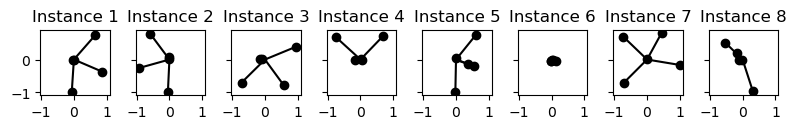

DECODER


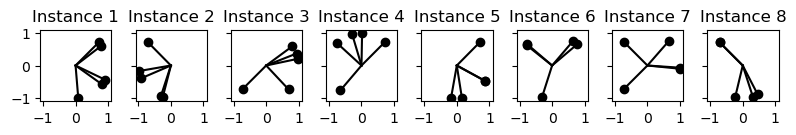

In [11]:
"""Plot the SAE's encoder and decoder weights."""

print("ENCODER")
plot_features_in_2d(
    data_log["W_enc"][-1],  # -1 for the weights at the last step
)

print("DECODER")
plot_features_in_2d(
    data_log["W_dec"][-1].transpose(
        -1, -2
    ),  # transpose to match encoder weights shape (5 feat on 2 ax)
)

That doesn't look good!  Many of the SAE's encoder weights (features) are zero! And the decoder weights (features) corresponding to the zero-encoder weights are pointing in essentially random directions.

Let's dig into this further by looking at feature sparsity levels over training. We should find that there are 2 types of features: ones which converge roughly to the expected `feature_probability` (which we set to $0.01$ previously), and ones which quickly converge to zero. These latter neurons are **"dead autoencoder features"**, and they're an annoying problem when training SAEs.

In [12]:
"""Plot fraction of active neurons (features) over training."""

def frac_active_line_plot(
    frac_active: Float[Tensor, "n_steps n_instances n_hidden_ae"],
    feature_probability: float,
):
    """Plots the fraction of active neurons over training."""
    n_steps, n_instances, n_hidden_ae = frac_active.shape
    y_max = feature_probability * 3
    fig = go.Figure(
        layout=dict(
            template="simple_white",
            title="Probability of SAE neurons being active during training",
            xaxis_title="Training Step",
            yaxis_title="Fraction of Active Neurons",
            yaxis_range=[0, y_max],
            width=1000,
        )
    )
    # Add a curve for each neuron for each instance.
    for inst in range(n_instances):
        for neuron in range(n_hidden_ae):
            fig.add_trace(
                go.Scatter(
                    x=list(range(0, n_steps)),
                    y=frac_active[:, inst, neuron].tolist(),
                    name=f"AE neuron #{neuron}",
                    mode="lines",
                    opacity=0.3,
                    legendgroup=f"Instance #{inst}",
                    legendgrouptitle_text=f"Instance #{inst}",
                )
            )
    # Add a horizontal line for the feature probability, and show figure.
    fig.add_hline(
        y=feature_probability,
        opacity=1,
        line=dict(color="black", width=2),
        annotation_text="Feature prob",
        annotation_position="bottom left",
        annotation_font_size=14,
    )
    fig.show()


# Plot it.
frac_active_line_plot(
    frac_active=torch.stack(data_log["frac_active"], dim=0),  # turn 2d list into 3d tensor
    feature_probability=feature_probability
)

### Addressing dead features: Neuron resampling

These "dead" neurons are a common problem when training SAEs. Fundamentally, they arise from the L1 penalty incentivizing neurons to be inactive.  Some recent research suggests that alternative SAE architectures may mitigate this issue by avoiding the L1 penalty altogether and using different ways of encouraging sparsity. There have also been a variety of mitigations proposed in the context of the standard L1-based SAE.

Here we provide an implementation of one of these mitigations, known as "neuron resampling." At a high level, the idea behind resampling is to re-initialize the weights corresponding to dead SAE neurons, so that they have the opportunity to "learn again".

We'll find that by addressing the dead features issue, the SAE will perform much better.

Specifically, we'll implement the following algorithm:

* For a model instance, over a specified time window, check for dead neurons.
* For each dead neuron:
    * Generate a new random vector `v` of length `n_input_ae`, and normalize it to have unit length.
    * Reset the decoder weights `W_dec[inst, dead_feature_idx, :]` to this new vector `v`.
    * Reset the encoder weights `W_enc[inst, :, dead_feature_idx]` to this new vector `v`.
    * Reset the encoder biases `W_enc[inst, dead_feature_idx]` to zero.

In [13]:
"""Add method for resampling neurons, and update the `optimize` method to use it."""

@torch.no_grad()
def resample_neurons(
    self: AutoEncoder,
    frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
) -> Tuple[List[List[str]], str]:  # -> (colors_for_neurons, title_with_resampling_info)
    """Resamples neurons dead for `dead_neuron_window` steps, according to `frac_active`."""
    # Get a tensor of dead neurons.
    dead_features_mask = frac_active_in_window.sum(0) < 1e-8  # -> [n_instances n_hidden_ae]
    n_dead = dead_features_mask.int().sum().item()

    # Get our random replacement values (-> [n_dead n_input_ae]).
    replacement_values = torch.randn((n_dead, self.cfg.n_input_ae), device=self.W_enc.device)
    replacement_values_normalized = (
        replacement_values / replacement_values.norm(dim=-1, keepdim=True) + 1e-8
    )

    # Reset W_enc, W_dec, and b_enc (we transpose W_enc to return a view with correct shape).
    self.W_enc.data.transpose(-1, -2)[dead_features_mask] = replacement_values_normalized
    self.W_dec.data[dead_features_mask] = replacement_values_normalized
    self.b_enc.data[dead_features_mask] = 0.0

    # Return data for visualising the resampling process.
    colors = [
        ["red" if dead else "black" for dead in dead_neuron_mask_inst]
        for dead_neuron_mask_inst in dead_features_mask
    ]
    title = f"resampling {n_dead}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title


# Update the `optimize` method to use the new `resample_neurons` method.
def optimize(
    self: AutoEncoder,
    model: Model,  # Toy Model of Superposition
    batch_sz: int = 1024,
    steps: int = 10_000,
    log_freq: int = 100,
    lr: float = 1e-3,
    lr_scale: Callable[[int, int], float] = constant_lr,
    neuron_resample_window: Optional[int] = None,  # in optimization steps
):
    """Optimizes the autoencoder using the given hyperparameters."""
    optimizer = torch.optim.Adam(list(self.parameters()), lr=lr)

    # Create lists to store data we'll eventually be plotting.
    frac_active_list = []  # fraction of active units (features) for each step
    data_log = {"frac_active": [], "W_enc": [], "W_dec": [], "titles": [], "colors": []}
    colors = None
    title = "No resampling"

    progress_bar = tqdm(range(steps))
    for step in progress_bar:
        # Normalize decoder weights at each step to prevent artificially small / sparse
        # features from large decoder weights.
        self.normalize_decoder()

        # Check for dead neurons, and resample them if found.
        if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
            frac_active_in_window = torch.stack(frac_active_list[-neuron_resample_window:], dim=0)
            colors, title = self.resample_neurons(frac_active_in_window)
        
        # Update learning rate.
        step_lr = lr * lr_scale(step, steps)
        for group in optimizer.param_groups:
            group["lr"] = step_lr

        # Get a batch of hidden activations from the model.
        with torch.inference_mode():
            features = model.generate_batch(batch_sz)
            h = einops.einsum(
                features,
                model.W,
                "batch_sz n_instances n_feat_gt, n_instances n_hidden n_feat_gt "
                "-> batch_sz n_instances n_hidden",
            )

        # Optimize.
        optimizer.zero_grad()
        l1_loss, l2_loss, loss, z, _ = self.forward(h)
        loss.backward()
        optimizer.step()

        # Calculate the sparsities and them to the list.
        frac_active = einops.reduce(
            (z.abs() > 1e-8).float(),
            "batch_sz n_instances hidden_ae -> n_instances hidden_ae",
            "mean",
        )
        frac_active_list.append(frac_active)

        # Display progress bar, and append new values for plotting.
        if step % log_freq == 0 or (step + 1 == steps):
            progress_bar.set_postfix(
                l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(),
                l2_loss=l2_loss.mean(0).sum().item(),
                lr=step_lr,
            )
            data_log["W_enc"].append(self.W_enc.detach().cpu())
            data_log["W_dec"].append(self.W_dec.detach().cpu())
            data_log["titles"].append(f"Step {step}/{steps}: {title}")
            data_log["frac_active"].append(frac_active.detach().cpu())
            data_log["colors"].append(colors)

    return data_log


# Add methods to SAE class.
AutoEncoder.resample_neurons = resample_neurons
AutoEncoder.optimize = optimize

### SAE training attempt #2

Now we'll try training our SAE again, this time with neuron resampling.

In [14]:
"""Train the SAE with neuron resampling."""

ae_cfg = AutoEncoderConfig(
    n_instances=8,
    n_input_ae=2,
    n_hidden_ae=5,
    l1_coeff=0.25,
)
sae = AutoEncoder(ae_cfg)

data_log = sae.optimize(
    model=model,
    steps=10_000,
    neuron_resample_window=1000,
    log_freq=1000,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
"""Post resampling training, plot the fraction of active neurons (features) over training."""

frac_active_line_plot(
    frac_active=torch.stack(data_log["frac_active"], dim=0),
    feature_probability=0.01,
)

We can see that the problem of dead features has been resolved...

ENCODER


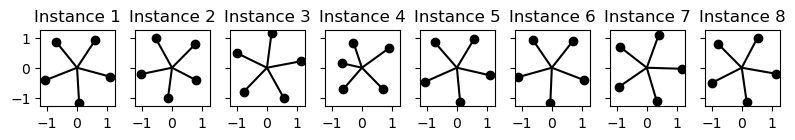

DECODER


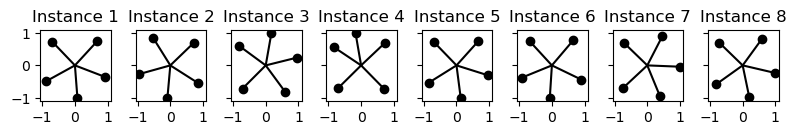

GROUND TRUTH


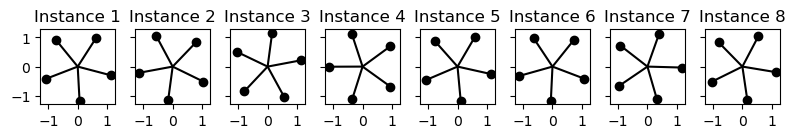

In [16]:
"""View the encoder, decoder, and ground truth features post resampling training."""

print("ENCODER")
plot_features_in_2d(
    data_log["W_enc"][-1],
)

print("DECODER")
plot_features_in_2d(
    data_log["W_dec"][-1].transpose(-1, -2),
)

print("GROUND TRUTH")
plot_features_in_2d(
    model.W,
)

And the feature directions inferred by the model are now what we expect! 

Furthermore, if we compare them to the ground-truth feature directions (the Toy Model's weights), we can see they match pretty well!

In conclusion, we've seen that properly implemented sparse autoencoders can accurately infer ground-truth sparse features underlying observed activations.

# (2) Sparse Autoencoders applied to language models

Now that we've trained SAEs on a toy model, we'll graduate to some more realistic models.

Currently, the open-source infrastructure for training SAEs is very much in development, and we'd love you to help build it out! But for now, we'll take an SAE which was trained on activations of a GELU-1l model (from Neel Nanda's HookedTransformer library). Specifically, these are the MLP neuron activations from a 1-layer transformer.

If you're not familiar with the transformer architecture, no worries -- you actually don't need to be for this exercise!  All you need to know is that these activations are internal model representations of a text sequence.

First, here's some code to load in sparse autoencoders. We'll load in two different SAEs, denoted with the parameter `version`. These have the same architectures & were trained in the same way, but with different random seeds. This is a robustness check -- if two different SAE runs find the same feature, that's evidence that the feature is universal rather than just a fluke of the training process.

We'll load in both of these autoencoders into the same `AutoEncoder` object (as 2 different **instances**).

A few notes / pieces of terminology:

- Because we're working with an MLP layer, we'll use `d_mlp` to denote the size of the MLP layer - this is equivalent to `n_input_ae` in the previous section. We'll keep using `n_hidden_ae` to refer to the autoencoder's hidden dimension.
- The **dictionary multiplier** (denoted `dict_mult` below) is the factor by which the autoencoder's hidden dimension is larger than the model's hidden dimension, in other words `n_hidden_ae = dict_mult * d_mlp`.
- We're  now working with a real language model rather than a toy data-generating process with known ground-truth features, so when we say "features" in this section we're referring to the autoencoder's hidden values rather than theoretical "true features" of the data-generation process.

### Imports and setup

In [4]:
from transformer_lens import HookedTransformer, FactoredMatrix
from transformer_lens.hook_points import HookPoint

from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

In [9]:
VERSION_DICT = {"run1": 25, "run2": 47}


def load_autoencoder_from_huggingface(versions: List[str] = ["run1", "run2"]):
    state_dict = {}

    for version in versions:
        version_id = VERSION_DICT[version]
        # Load the data from huggingface (both metadata and state dict)
        sae_data: dict = download_file_from_hf(
            "NeelNanda/sparse_autoencoder", f"{version_id}_cfg.json"
        )
        new_state_dict: dict = download_file_from_hf(
            "NeelNanda/sparse_autoencoder", f"{version_id}.pt", force_is_torch=True
        )
        # Add new state dict to the existing one
        for k, v in new_state_dict.items():
            state_dict[k] = torch.stack([state_dict[k], v]) if k in state_dict else v

    # Get data about the model dimensions, and use that to initialize our model (with 2 instances)
    d_mlp = sae_data["d_mlp"]
    dict_mult = sae_data["dict_mult"]
    n_hidden_ae = d_mlp * dict_mult

    cfg = AutoEncoderConfig(
        n_instances=2,
        n_input_ae=d_mlp,
        n_hidden_ae=n_hidden_ae,
    )

    # Initialize our model, and load in state dict
    autoencoder = AutoEncoder(cfg)
    autoencoder.load_state_dict(state_dict)

    return autoencoder


autoencoder = load_autoencoder_from_huggingface()

### Language Model

We also load in our model from TransformerLens, and inspect it. The model we'll be working with is 1-layer, with `d_mlp = 2048`. Note that the autoencoder we defined above has a dictionary multiplier of 8, meaning it has 2048 * 8 = 16384 neurons!

In [ ]:
model = HookedTransformer.from_pretrained("gelu-1l").to(device)

print(model)

Lastly, we load in a large batch of data which is representative of the data which the autoencoder was trained on:

In [ ]:
# from datasets import clear_cache, load_from_disk
# clear_cache()

In [ ]:
data = load_dataset("NeelNanda/c4-code-20k", split="train", download_mode="force_redownload")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)

# this will function as our input to the language model
all_tokens = tokenized_data["tokens"]
print("Tokens shape: ", all_tokens.shape)

## Working with a language model SAE

Now that we've loaded the sparse autoencoder, let's verify that it actually functions well as a sparse autoencoder! This will also help familiarize you with working with these models. Specifically, we want to verify two things: (1) that the SAE activations are indeed sparse, and (2) That the SAE outputs are indeed a pretty good reconstruction of the inputs.

### Exercise - validate the sparsity of the SAE activations


You should fill in the `get_feature_probability` function below, which returns the fraction of time each autoencoder feature fires (as a tensor of shape `(2, n_hidden_ae)` - the latter `2` dimension because we have 2 different instances, and you should return the feature probabilities for each feature in both instances).

Some of this should be familiar - in the previous sections you've already written code to calculate the model's hidden activations, and seen some that measured feature sparsity (if you investigated the resampling autoencoder neurons section). The only new thing here is how the hidden activations are generated. You should:

- Run the transformer model on `tokens`, and get the post-GELU activations with shape `(batch_size, seq_len, d_mlp)`.
- Rearrange this into shape `(batch_size * seq_len, d_mlp)`, because the activations at each token are a separate input for our autoencoder.
- Duplicate this tensor into `(batch_size * seq_len, 2, d_mlp)`, because we have 2 different autoencoder instances.
- Run the autoencoder on these activations, finding the activations (and the fraction of times the feature is active, over the `batch_size * seq_len` dimension).


In [ ]:
@torch.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, ""]:
    """
    Returns the feature activation probability for the autoencoder on the given batch of tokens.
    """
    batch_size, seq_len = tokens.shape

    # Get the activations from the transformer language model
    logits, cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])
    mlp_acts = cache["blocks.0.mlp.hook_post"]

    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    # Reshape and duplicate the activations to the desired size for both AE models
    mlp_acts_reshaped = einops.repeat(
        mlp_acts, "batch seq d_mlp -> (_____ _____) __________ d_mlp", instances=2
    )
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, d_mlp)

    # Get the sparse AE hidden layer activations to the language model activations
    l1_loss, l2_loss, loss, acts, h_reconstructed = autoencoder.forward(mlp_acts_reshaped)
    assert acts.shape == (batch_size * seq_len, 2, autoencoder.cfg.n_hidden_ae)
    binary_acts = (acts > 0).mean()
    return binary_acts.mean(0)


# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i : i + 50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
# average over the feature probabilities
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

#### Solution

In [ ]:
@torch.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, ""]:
    """
    Returns the feature activation probability for the autoencoder on the given batch of tokens.
    """
    batch_size, seq_len = tokens.shape

    # Get the activations from the transformer language model
    logits, cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])
    mlp_acts = cache["blocks.0.mlp.hook_post"]

    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    # Reshape and duplicate the activations to the desired size for both AE models
    mlp_acts_reshaped = einops.repeat(
        mlp_acts, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2
    )
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    # Get the sparse AE hidden layer activations to the language model activations
    l1_loss, l2_loss, loss, acts, h_reconstructed = autoencoder.forward(mlp_acts_reshaped)
    assert acts.shape == (batch_size * seq_len, 2, autoencoder.cfg.n_hidden_ae)
    binary_acts = (acts > 0).float()
    return binary_acts.mean(0)


# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i : i + 50], model, autoencoder)
    for i in tqdm(range(0, 500, 50))
]
# average over the feature probabilities
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

In [ ]:
# Visualize distribution of sparsity levels across features for each instance
for i, lf in enumerate(log_freq):
    hist(
        lf,
        title=f"Instance #{i+1}: Log Frequency of Features",
        labels={"x": "log<sub>10</sub>(freq)"},
        histnorm="percent",
        template="ggplot2",
    )

There are a few things to notice here.

First, the histograms are highly consistent between the two model instances.  That's a good sign that the SAE training is robust!

Second, the features are indeed sparse, with the bulk of the features activating significantly less than 1% of the time.

Third, the features sparsity values are bimodal. We won't dig into this here, but further investigation of the lower-frequency group has revealed that almost all these features are meaningless, with very high cosine similarity to each other, suggesting that these are an artifact of this particular SAE's optimization rather than meaningful features.

### Exercise - validate the SAE reconstruction loss


You should fill in the `get_reconstruction_loss` function below, which returns the average reconstruction loss (i.e. $L_2$ loss) of each autoencoder instance on a batch of data, in the form of a list of 2 values.

This should be very similar to the previous exercise, except rather than getting the activations & returning their sparsity, you should return the average reconstruction loss.

In [ ]:
@torch.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
):
    """
    Returns the reconstruction loss of the autoencoder on the given batch of tokens.
    """
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    mlp_acts_reshaped = einops.repeat(
        mlp_acts, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2
    )
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    # Get the l2 loss and reconstructed post-GELU activations
    l1_loss, l2_loss, loss, acts, mlp_acts_reconstructed = autoencoder.forward(mlp_acts_reshaped)
    assert l2_loss.shape == (batch_size * seq_len, 2)
    assert mlp_acts_reconstructed.shape == (______ * ______, 2, model.cfg.______)

    print(
        "Avg cos sim of neuron reconstructions with ground-truth: ",
        torch.cosine_similarity(mlp_acts_reconstructed, mlp_acts_reshaped, dim=0)
        .mean(-1)
        .tolist(),
    )
    print(
        "Avg L2 norm of acts: ",
        einops.reduce(mlp_acts_reshaped.pow(2), "batch inst d_mlp -> inst", "mean").tolist(),
    )
    print("Avg mean-squared error of neuron reconstructions: ", l2_loss.mean(0).tolist())


print(get_reconstruction_loss(all_tokens[:10], model, autoencoder))

#### Solution

In [ ]:
@torch.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
):
    """
    Returns the reconstruction loss of the autoencoder on the given batch of tokens.
    """
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    mlp_acts_reshaped = einops.repeat(
        mlp_acts, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2
    )
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    # Get the l2 loss and reconstructed MLP activations
    l1_loss, l2_loss, loss, acts, mlp_acts_reconstructed = autoencoder.forward(mlp_acts_reshaped)
    assert l2_loss.shape == (batch_size * seq_len, 2)
    assert mlp_acts_reconstructed.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    print(
        "Avg cos sim of neuron reconstructions with ground-truth: ",
        torch.cosine_similarity(mlp_acts_reconstructed, mlp_acts_reshaped, dim=0)
        .mean(-1)
        .tolist(),
    )
    print(
        "Avg L2 norm of acts: ",
        einops.reduce(mlp_acts_reshaped.pow(2), "batch inst d_mlp -> inst", "mean").tolist(),
    )
    print("Avg mean-squared error of neuron reconstructions: ", l2_loss.mean(0).tolist())


get_reconstruction_loss(all_tokens[:10], model, autoencoder)

You should find that the reconstruction loss is around 0.016 (and about the same for encoder-B). You can compare this to the average squared $L_2$ norm of the activations to get an idea of how good this is - this value is around 0.11, so we're doing a pretty good job (albeit not perfect) of reconstructing the activations.

### Exercise - find highest-activating tokens

Now we've sanity-checked these SAEs, let's try to interpret the SAE features!

The first thing we should do is find the sequences in the dataset that most strongly activate each feature. This gives decent idea of what this feature represents, especially since the features are sparsely active.

(Note that this shouldn't be the end point of our analysis - the top activating examples look like they fit a pattern, but other examples that activate the feature less strongly don't fit the same pattern. Ideally you'd want to perform tests like passing particular sequences through the model which you expect will / won't cause your feature to activate, in order to test your hypothesis about the feature's function. To be fully confident in your interpretation, you'd also like to perform causal interventions by modifying feature values. However, viewing top-activating examples is a very useful starting point.)

The function `highest_activating_tokens` returns a tensor of shape `(k, 2)`, where the `i`-th element of this tensor are the (batch, seq) indices of the `i`-th highest-activating token (i.e. the token on which the `feature_idx`-th neuron in the autoencoder has the largest activations). If also returns a tensor of shape `(k,)` containing these activation values.

Note that the function also takes a boolean argument `autoencoder_B`, which is `True` when we're looking at the second autoencoder (i.e. the second instance).

Tip - you can make this function a lot more efficient by calculating the activations explicitly, rather than by extracting `acts` from the 5-tuple returned by `autoencoder.forward`. This is because you only need one feature - it's wasteful to calculate all 16384! You can just copy & modify code from the start of the `AutoEncoder.forward` method.

You can test your function by running the code in the cell below. Click the toggle below to see what sequences you should be getting.


<details>
<summary>Spoiler: sequences you should be getting</summary>

If you run the function with at least a batch size of ~100, you should observe the following pattern: **the top-activating tokens for feature #7 are consistently pronouns like ` I`, ` you` or ` it`, commonly following either the word ` and` or ` but`.

</details>

In [ ]:
@torch.inference_mode()
def highest_activating_tokens(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    feature_idx: int,
    instance_idx: int = 0,
    k: int = 10,
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    """
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    """
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run
    cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])[1]
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    mlp_acts_reshaped = einops.rearrange(mlp_acts, "batch seq d_mlp -> (batch seq) d_mlp")

    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code will be modified from the first part of the 'forward' method of the AutoEncoder class

    h_cent = (
        mlp_acts_reshaped - autoencoder.b_dec[instance_idx]
    )  # this autoencoder preprocesses inputs by subtracting the bias of the decoder, which serves as a proxy for the mean layer activations
    acts = einops.einsum(
        h_cent,
        autoencoder.W_enc[instance_idx, :, feature_idx],
        "batch_size d_mlp, d_mlp -> batch_size",
    )

    # Get the top k largest activations
    top_acts_values, top_acts_indices = acts.topk(k)

    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values


def display_top_sequences(top_acts_indices, top_acts_values, tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, all_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            new_str_token = (
                model.to_single_str_token(tokens[batch_idx, i].item())
                .replace("\n", "\\n")
                .replace("<|BOS|>", "|BOS|")
            )
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)


tokens = all_tokens[:200]
top_acts_indices, top_acts_values = highest_activating_tokens(
    tokens, model, autoencoder, feature_idx=11, instance_idx=7
)
display_top_sequences(top_acts_indices, top_acts_values, tokens)

#### Solution

In [ ]:
@torch.inference_mode()
def highest_activating_tokens(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    feature_idx: int,
    instance_idx: int = 0,
    k: int = 10,
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    """
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    """
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run
    cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])[1]
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    mlp_acts_reshaped = einops.rearrange(mlp_acts, "batch seq d_mlp -> (batch seq) d_mlp")

    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code will be modified from the first part of the 'forward' method of the AutoEncoder class

    h_cent = (
        mlp_acts_reshaped - autoencoder.b_dec[instance_idx]
    )  # this autoencoder preprocesses inputs by subtracting the bias of the decoder, which serves as a proxy for the mean layer activations
    acts = einops.einsum(
        h_cent,
        autoencoder.W_enc[instance_idx, :, feature_idx],
        "batch_size n_input_ae, n_input_ae -> batch_size",
    )

    # Get the top k largest activations
    top_acts_values, top_acts_indices = acts.topk(k)

    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values


def display_top_sequences(top_acts_indices, top_acts_values, tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, all_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            new_str_token = (
                model.to_single_str_token(tokens[batch_idx, i].item())
                .replace("\n", "\\n")
                .replace("<|BOS|>", "|BOS|")
            )
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)


tokens = all_tokens[:200]
top_acts_indices, top_acts_values = highest_activating_tokens(
    tokens, model, autoencoder, feature_idx=7, instance_idx=0
)
display_top_sequences(top_acts_indices, top_acts_values, tokens)

### Exercise - compute a feature's logit effects

Understanding when a feature activates tells us only half the story about a feature. We are also interested in the feature's *effects* on downstream computation. In general, effects can be complicated and nonlinear in deep models. However, in this one-layer model, we can simply check is the direct effect of the feature's activations on the model's outputs.  (Note that since even large language models typically have residual connections, there always exists a direct linear path from any layer's features to the model outputs. Thus we can apply this same technique in larger models, though it may no longer be as accurate a description of the feature's function).

Try to find the 10 tokens that `feature_idx = 7` (shown above) most strongly boosts / supresses. In other words, when you multiply the decoder weight with the GELU-1l model's MLP output matrix and unembedding matrix, which tokens are most affected?  We call these "logit effects," since "logits" are the term for the unnormalized log probabilities of outputing each token in the model's vocabulary.



<details>
<summary>Spoilers </summary>

You should find that the most boosted token is `'ll` - not surprising given this commonly follows `I`, `we` and `it`. It seems likely that this feature is mostly a **bigram feature**. Some other highly boosted tokens also commonly follow these pronouns, e.g. `hope`, `wouldn`, `definitely`.

Note - when we say **bigram feature**, we mean features which seem to exist in order to model bigram frequences: *"this token is X, so next token is more/less likely to be Y"*. These are uninteresting because they don't require attention heads to move information around, they're just the feature responding to something already in the residual stream & writing directly to the output.

However, this feature might not only be modelling bigrams. We saw that it activates most when the pronoun is followed by tokens like `and` or `but`. Possibly this is better described as a **trigram feature**, which is slightly more interesting because it must involve attention heads in some way. Can you find any **[skip-trigram](https://transformer-circuits.pub/2021/framework/index.html#interpretation-as-skip-trigrams) features**?

The bottom 10 tokens don't seem very interpretable - this is pretty common (most of the time model components are better thought of as boosting rather than suppressing components - although [not all the time](https://arxiv.org/abs/2310.04625)!)

</details>

In [ ]:
feature_idx = 7  # example
instance_idx = 0

# Get the decoder vector for the example feature
W_dec_vector = autoencoder.W_dec[instance_idx, feature_idx]

# Get downstream model weights
W_out = model.W_out[0]  # shape [d_mlp, d_model] -- output projection from MLP activations
W_U = (
    model.W_U
)  # shape [d_model, d_vocab] -- "unembedding" weights that map to model output logits

# Do the matrix multiplication with the decoder vector and downstream model matrices
W_dec_logits = W_dec_vector @ W_out @ W_U

# Select the top and bottom 10 tokens
top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)

#### Solution

In [ ]:
feature_idx = 7  # example
instance_idx = 0

# Get the decoder vector for the example feature
W_dec_vector = autoencoder.W_dec[instance_idx, feature_idx]

# Get downstream model weights
W_out = model.W_out[0]  # shape [d_mlp, d_model] -- output projection from MLP activations
W_U = (
    model.W_U
)  # shape [d_model, d_vocab] -- "unembedding" weights that map to model output logits

# Do the matrix multiplication with the decoder vector and downstream model matrices
W_dec_logits = W_dec_vector @ W_out @ W_U

# Select the top and bottom 10 tokens
top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)

### Optional Exercise - explore some more features!


There are many more fun features to find in this model. In the first 1000 features for instance A, you should find:

- A feature which fires on Django syntax (the Python library), and predicts the string `django` following an open bracket (this is importantly different from just a bigram feature, because it requires the context before the left braacket to detect that the library is Django).
- A feature which fires on dashes following the word `multi`, and predicts words which commonly follow (e.g. `multi-million` or `multi-purpose`).
- A feature which fires on the digit `0` when it's part of a year (particularly when it's the hundreds digit) e.g. in `2012`, and boosts `0` and `1`.

<br>

You can look at different features by rerunning the code above with different `feature_idx` arguments. Alternatively, you could search for features by writing some code to pass in text and return the set of features that activate for that text!


# (3) Exploring SAE features extracted from larger models

While SAEs are theoretically interesting, the present excitement around them owes primarily to their *empirical* success in aiding interpretability of large language models* at scale*. In this section, we'll take a look at some published tools and interfaces for interacting with large SAEs trained on large models.

Neuronpedia is a great interface (not my creation! big kudos to their team for the amazing work) that allows you to explore SAEs trained on publicly released models. We'll focus to start on recently released SAEs trained on Gemma-2-2b, an open-weights model from Google DeepMind.

## Browsing feature visualizations

Go to this link: https://www.neuronpedia.org/gemma-2-2b.  Type in a prompt. Anything you like!

Click Search.  You are now seeing the SAE features, across all the layers of the model (separate SAEs trained for each layer), that activate at different token positions in response to this prompt, ranked by their activation strength. Here's an explanation of what you're seeing



*   The names of the features will be things like `25-gemmascope-res-16k/13749`.  These indicate the layer (the "25") and the index of the feature in the SAE (the "13749").
*    The feature visualization will show you the activity (green highlights) of the feature across the different tokens of the prompt you input.
*    If you click on the feature, a new tab will open, and you'll be able to see a larger set of examples that cause this feature to activate, and test how the feature responds to prompts you come up with.
*    You'll notice each feature is given an English-language description of what it represents.  **These descriptions are themselves generated by an LLM, which was shown the same information you are seeing and asked to interpret the feature's function! ** Often these explanations are slightly off, or underspecific, or in some cases wildly wrong, especially for more complex/subtle features.  Nevertheless, they are often pretty helpful.
*    The interface also shows you the logits most strongly directly influenced by that feature (via its direct residual connections to the model output). Note that logit effects are often misleading / difficult to interpret for features in all but the final layers of the network, since early and mid-layer features primarily influence network outputs through indirect pathways.
*    You will also see the "density" of the feature, i.e. the percentage of examples for which it activates.  A small number of features activate on a high percentage (e.g. 50%) of inputs -- these tend to be less interpretable.  The sparse features are usually more interesting!
*    You'll also be shown histogram of the feature's activation and of its logit effects.

**Recommendations for understanding features: focus on: (1) the LLM-generated description of the feature (but don't trust it too much) (2) The examples that activate the feature (need to click on it to see all of these), and (3) check the logit effects, but don't expect them to make sense unless the feature lives in one of the later layers of the model (this model has 25 layers).**

Note that the interface also allows you to sort by a feature's activations at particular token positions (click on the token of interest towards the top of the page), or in particular layers (choose from the drop-down menu).


Some illustrative prompts to try:


1.   `John didn't want to share his remaining candy with his sister Mary, so when she asked if he had any left, he said he didn'torch.` -- You should be able to find an active feature related to lying or pretending.
2.   `The opposite of big is` -- on the "is" token, you should find some features in later layers of the model with strong positive influence on the logits for "small" and related words.
3.   `Cassandra was upset with her brother Jaime after he stole her pudding. "Well aren't you the best brother in the world?" she said.` -- you should be able to find a feature that detects sarcasm, and which influences the logit for the token "sarcas," which fires on the "said" token!


Some questions to keep in mind:

1.  How do features in early, middle, and late layers differ qualitatively?
2.  How interpretable do you find the features?  That is, to what extent is there a consistent, easy-to-articulate rule that captures all the examples that activate the feature?
3.  How consistent are the conditions under which a feature activates (i.e. its activating examples) with its logit effects, usually?
4.  How good of a job are the LLM-generated interpretations doing?
5.  How interpretable are sparser features vs. denser features?

## Feature Steering

Go to this link: https://www.neuronpedia.org/steer/gemma-2-2b. This will allow you to experiment with "feature steering" -- perturbing model activity along feature directions and seeing how it influences the model outputs. Type in a prompt in the upper-left (or choose one of the presets), and choose a feature to "steer" with.  You can choose one of the presets, or pick one of the defaults, or enter a specefic feature layer+index from your earlier explorations. You can use sliders to control the feature steering values.

The interface is pretty intuitive, so not much more explanation is needed.  Here are some things to explore:



*   Often, features only have a noticeable effect when it's context-appropriate. For instance, try steering with the "San Francisco" feature at the default strength 20, for the prompts "My favorite city is" and "My favorite vegetable is"
*   High enough feature steering values can cause the model to ignore the prompt/context, and/or to produce nonsensical outputs.  Try cranking up the "dogs" feature to 100 with the prompt "My favorite vegetable is"
*   What happens when you steer with negative values? Try setting the New York feature to a large negative value and inputting "The Empire State Building is located in the city of"
*   Try switching the model to Gemma-2-2B-IT, the instruction-tuned variant of the model.  This will allow you to phrase prompts to the model as questions you would ask a chatbot, rather than as partially completed sentences.

In general, activation steering of models is an empirical science and an art. It takes some time to get an intuition for how steering works and how its effects relate to the feature in question. Spend some time playing around with it!

## Features from Claude 3 Sonnet

The Gemma-2-2B model you've been playing with above is intelligent for its size, but pretty far from state-of-the-art.  Let's get a sense for what SAE features look like on a model that's closer to the capabilities frontier, Claude 3 Sonnet (it's not quite state-of-the-art, and was recently replaced by the much-smarter Claude 3.5 Sonnet, but we'll take what we can get.  Things move fast in LLM world!).

Since this model is not openly released, the exploration interfaces available for it are less extensive / interactive. Nevertheless, it's still worth taking a look at the following:

*   Take a quick scroll through [this compilation of feature visualizations.](https://transformer-circuits.pub/2024/scaling-monosemanticity/features/index.html?featureId=34M_31164353). Using the left sidebar, you can look in-depth at the features that were highlighted in [the associated paper](https://transformer-circuits.pub/2024/scaling-monosemanticity/), and also at a set of 1000 randomly sampled features.  It's worth looking at the randomly sampled features, to get a sense of what the "average" feature looks like.


*   **Feature geometry.**  The paper also provides a [visualization of UMAP-based "neighborhoods"](https://transformer-circuits.pub/2024/scaling-monosemanticity/umap.html?targetId=34m_31164353) surrounding several features of interest, with proximity determined by cosine similarity of feature decoder vectors. Spend some time with these plots for a few different features, to get a sense of how functionally related features cluster together.


